In [84]:
import os
import sys
import json
from datetime import timedelta

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from modules.pull_data import pull_and_append
from modules.flattening_json import flatten_extract_params, flatten_row, flatten_nested_column

In [156]:
data_path = "./data/data.json"

# project_id.dataset_id.event_YYYYMMDD
project_id = "emojioracle-342f1"
dataset_id = "analytics_481352676"

# service account key from Google Cloud IAM
bigquery_key = './keys/colab.json'
credentials = service_account.Credentials.from_service_account_file(bigquery_key)

In [157]:
# will pull what is missing from BigQuery and merge into data_path
pull_and_append(credentials, project_id, dataset_id, data_path)

Loaded existing data.
Latest event date in existing data: 20250411
Fetching table: events_20250412
Updated data.json with 104 new rows.


In [158]:
# load the data merged by pull_and_append into df
df = pd.read_json(data_path)

In [159]:
# flattenning

df = pd.DataFrame([flatten_row(row) for _, row in df.iterrows()]) # for wtfs refer to ./modules/flattening_json.py

In [ ]:
df.columns

Index(['event_date', 'event_timestamp', 'event_name',
       'event_previous_timestamp', 'event_value_in_usd',
       'event_bundle_sequence_id', 'event_server_timestamp_offset', 'user_id',
       'user_pseudo_id', 'user_first_touch_timestamp', 'stream_id', 'platform',
       'is_active_user', 'batch_event_index', 'batch_page_id',
       'batch_ordering_id', 'event_params.ga_session_id',
       'event_params.firebase_screen_id', 'event_params.ga_session_number',
       'event_params.ad_platform', 'event_params.firebase_screen_class',
       'event_params.ad_shown_where', 'event_params.ad_unit_id',
       'event_params.engaged_session_event',
       'event_params.firebase_event_origin', 'user.first_open_time',
       'user.ga_session_number', 'user.ga_session_id',
       'privacy_info.analytics_storage', 'privacy_info.ads_storage',
       'privacy_info.uses_transient_token', 'user_ltv', 'device.category',
       'device.mobile_brand_name', 'device.mobile_model_name',
       'device.mobi

In [160]:
df['user_pseudo_id'].nunique()

22

C:\Users\can_s\AppData\Local\Temp\ipykernel_10108\94595523.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



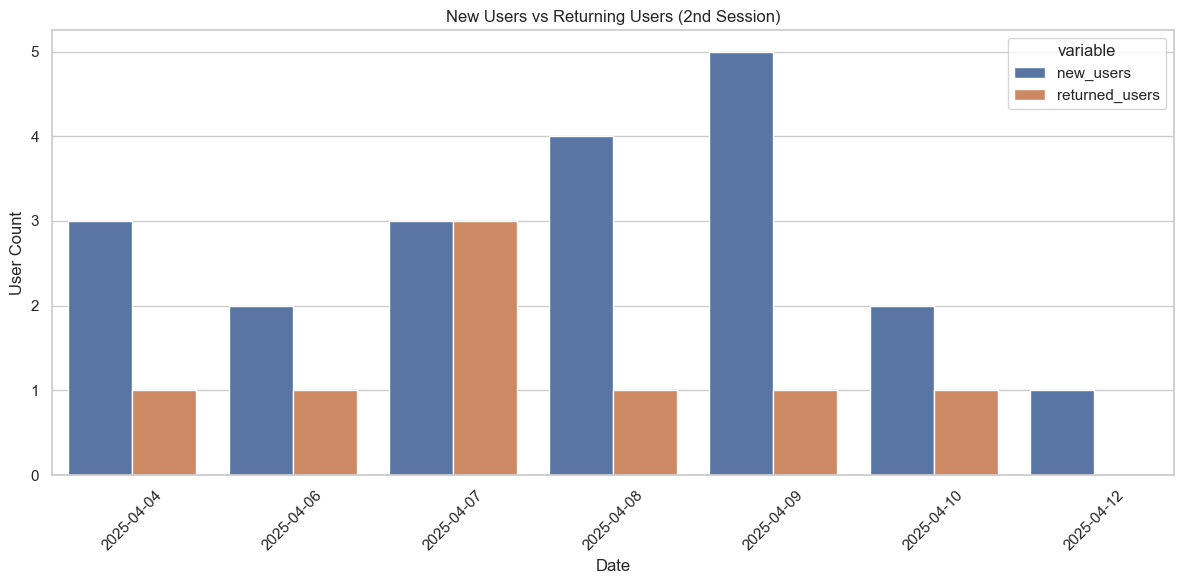

In [161]:
# Convert timestamps if needed
df['event_date'] = pd.to_datetime(df['event_date'], format='%Y%m%d')
df['first_open'] = pd.to_datetime(df['user.first_open_time'], unit='ms')

# Step 1: Get users with their first session date
new_users = df[df['user.ga_session_number'] == 1].copy()
new_users = new_users[['user_pseudo_id', 'first_open']].drop_duplicates()

# Step 2: Get all sessions of these users
all_sessions = df[df['user_pseudo_id'].isin(new_users['user_pseudo_id'])]
all_sessions['session_number'] = df['user.ga_session_number']

# Step 3: For each new user, check if they had a second session on a later date
# Merge to get first_open per user in all_sessions
all_sessions = all_sessions.merge(new_users, on='user_pseudo_id', suffixes=('', '_first'))

# Keep sessions after the first open time and with session_number > 1
returned_users = all_sessions[
    (all_sessions['session_number'] > 1) &
    (all_sessions['event_date'] > all_sessions['first_open'].dt.floor('D'))
]

# Step 4: Aggregate
# Count of new users per day
new_user_counts = new_users.groupby(new_users['first_open'].dt.date)['user_pseudo_id'].nunique().reset_index()
new_user_counts.columns = ['event_date', 'new_users']

# Count of new users who returned
returned_user_counts = returned_users.groupby(returned_users['first_open'].dt.date)['user_pseudo_id'].nunique().reset_index()
returned_user_counts.columns = ['event_date', 'returned_users']

# Merge the two
summary = pd.merge(new_user_counts, returned_user_counts, on='event_date', how='left').fillna(0)

# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=summary.melt(id_vars='event_date', value_vars=['new_users', 'returned_users']),
            x='event_date', y='value', hue='variable')
plt.xticks(rotation=45)
plt.title('New Users vs Returning Users (2nd Session)')
plt.ylabel('User Count')
plt.xlabel('Date')
plt.tight_layout()
plt.show()



In [162]:
df['event_params.current_qi'].value_counts().head(10)

event_params.current_qi
10    424
9     422
12    417
11    406
5     399
6     392
8     386
7     375
1     342
4     341
Name: count, dtype: int64

C:\Users\can_s\AppData\Local\Temp\ipykernel_10108\3035254175.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



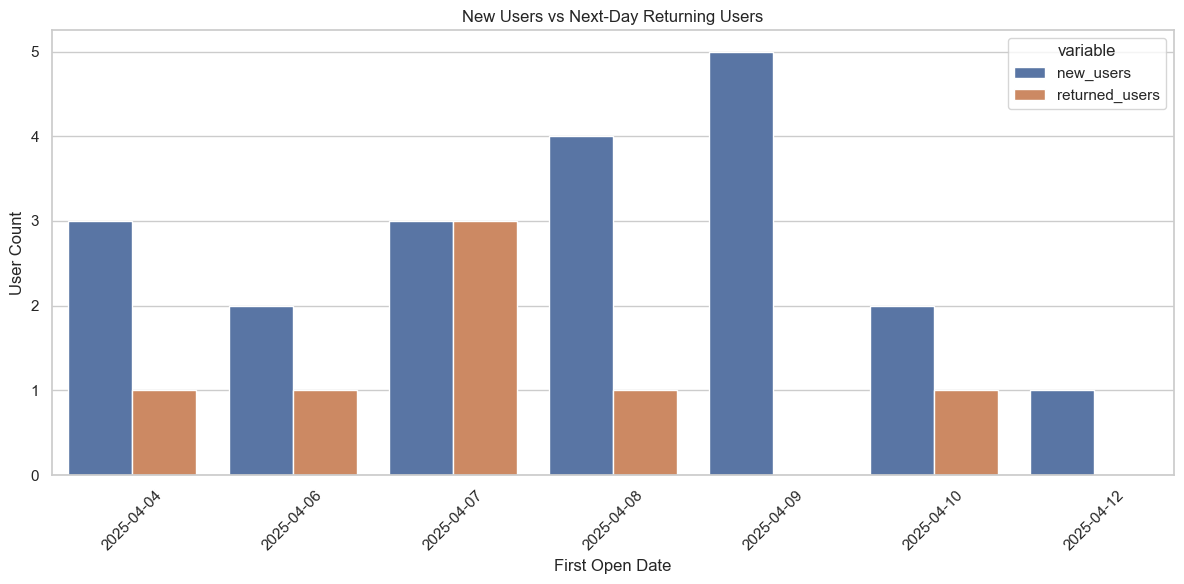

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert timestamps if needed
df['event_date'] = pd.to_datetime(df['event_date'], format='%Y%m%d')
df['first_open'] = pd.to_datetime(df['user.first_open_time'], unit='ms')

# Step 1: Get users with their first session date
new_users = df[df['user.ga_session_number'] == 1].copy()
new_users = new_users[['user_pseudo_id', 'first_open']].drop_duplicates()

# Step 2: Get all sessions of these users
all_sessions = df[df['user_pseudo_id'].isin(new_users['user_pseudo_id'])]
all_sessions['session_number'] = df['user.ga_session_number']

# Merge to get first_open per user in all_sessions
all_sessions = all_sessions.merge(new_users, on='user_pseudo_id', suffixes=('', '_first'))

# Step 3: Only include users who returned the next day
all_sessions['next_day'] = all_sessions['first_open'].dt.floor('D') + pd.Timedelta(days=1)

returned_users = all_sessions[
    (all_sessions['session_number'] > 1) &
    (all_sessions['event_date'] == all_sessions['next_day'])
]

# Step 4: Aggregate counts
new_user_counts = new_users.groupby(new_users['first_open'].dt.date)['user_pseudo_id'].nunique().reset_index()
new_user_counts.columns = ['event_date', 'new_users']

returned_user_counts = returned_users.groupby(returned_users['first_open'].dt.date)['user_pseudo_id'].nunique().reset_index()
returned_user_counts.columns = ['event_date', 'returned_users']

# Merge for plotting
summary = pd.merge(new_user_counts, returned_user_counts, on='event_date', how='left').fillna(0)

# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=summary.melt(id_vars='event_date', value_vars=['new_users', 'returned_users']),
    x='event_date', y='value', hue='variable'
)
plt.xticks(rotation=45)
plt.title('New Users vs Next-Day Returning Users')
plt.ylabel('User Count')
plt.xlabel('First Open Date')
plt.tight_layout()
plt.show()


In [164]:
df_sessions = df[df['event_name'].isin(['session_start', 'user_engagement'])]

# Step 1: Convert timestamps
df['event_datetime'] = pd.to_datetime(df['event_timestamp'], unit='us')
df['event_day'] = df['event_datetime'].dt.normalize()  # or .dt.normalize() if you prefer datetime objects

# Step 2: Group by user and day
grouped = df.groupby(['user_pseudo_id', 'event_day'])

# Step 3: Calculate session duration (max - min for each group)
session_durations = grouped['event_datetime'].agg(session_start='min', session_end='max')
session_durations['session_duration'] = (session_durations['session_end'] - session_durations['session_start']).dt.total_seconds()

# Step 4: Get mean session duration per user per day
mean_session_duration = session_durations.groupby(['user_pseudo_id', 'session_start']).agg(mean_duration=('session_duration', 'mean')).reset_index()

# Optional: Sort to inspect
mean_session_duration.sort_values(by='mean_duration', ascending=False).head()

,user_pseudo_id,session_start,mean_duration
24,d35c6c27e327622b39553d4257f1b16d,2025-04-06 06:47:22.323,58166.500001
8,278d01b19c1cc34cd5e6eda210c34619,2025-04-07 05:59:24.942,55329.614000
30,ddf2acb862daf1f5e1e9dff579ec87d7,2025-04-06 04:26:35.906,53547.191125
29,ddf2acb862daf1f5e1e9dff579ec87d7,2025-04-05 06:04:19.931,41814.952002
15,88fb7dc197cf3898687fada0732f68fb,2025-04-08 04:11:44.747,40772.501000


In [ ]:
# Make sure event time is in datetime
df['event_datetime'] = pd.to_datetime(df['event_timestamp'], unit='us')
df['event_day'] = df['event_datetime'].dt.date

# Sort by user and time
df = df.sort_values(['user_pseudo_id', 'event_datetime'])

# Calculate time difference between events for each user
df['prev_event_time'] = df.groupby('user_pseudo_id')['event_datetime'].shift()
df['time_since_last_event'] = (df['event_datetime'] - df['prev_event_time']).dt.total_seconds()

,mean_duration_seconds,mean_duration_minutes
count,28.000000,28.000000
mean,299.367024,4.989450
std,280.414695,4.673578
min,16.353001,0.272550
25%,91.550753,1.525846
50%,236.620504,3.943675
75%,426.376625,7.106277
max,1228.347983,20.472466


In [217]:
# Sessionization logic: 
# Assign session IDs based on time gaps between consecutive events.
# A new session is created if the gap between events exceeds the session gap threshold or if there is no previous event.

# 1. Set session gap (in seconds) to define when a new session starts
session_gap = 60  # 1 minute
session_bound_threshold = 5  # 5 seconds

# 2. Identify new sessions based on time gap exceeding the session gap threshold
df['new_session'] = (df['time_since_last_event'].isna()) | (df['time_since_last_event'] > session_gap)

# 3. Assign unique session IDs to each session per user
df['session_id'] = df.groupby('user_pseudo_id')['new_session'].cumsum()

# 4. Calculate session start and end times
# Group data by user and session, then aggregate the earliest and latest timestamps for each session
session_bounds = df.groupby(['user_pseudo_id', 'session_id']).agg(
    session_start=('event_datetime', 'min'),  # First event in the session
    session_end=('event_datetime', 'max')     # Last event in the session
)

# 5. Calculate session duration in seconds (difference between session start and session end)
session_bounds['duration'] = (session_bounds['session_end'] - session_bounds['session_start']).dt.total_seconds()

# 6. Filter out sessions that are shorter than 5 seconds (unrealistic short sessions)
session_bounds = session_bounds[session_bounds['duration'] >= session_bound_threshold]

# 7. Add the event day for each session
# Extract the date of the session's start time (calendar day)
session_bounds = session_bounds.reset_index()
session_bounds['event_day'] = session_bounds['session_start'].dt.date

# Now `session_bounds` contains:
# - session_start: The start time of the session
# - session_end: The end time of the session
# - duration: The duration of the session in seconds
# - event_day: The calendar day the session took place on

# You can now use `session_bounds` to analyze session lengths, calculate daily averages, etc.


In [ ]:
mean_durations = session_bounds.groupby(['user_pseudo_id', 'event_day'])['duration'].mean().reset_index()
mean_durations.rename(columns={'duration': 'mean_duration_seconds'}, inplace=True)

mean_durations.head()
mean_durations['mean_duration_minutes'] = mean_durations['mean_duration_seconds'] / 60
mean_durations.describe()

,mean_duration_seconds,mean_duration_minutes
count,28.000000,28.000000
mean,299.367024,4.989450
std,280.414695,4.673578
min,16.353001,0.272550
25%,91.550753,1.525846
50%,236.620504,3.943675
75%,426.376625,7.106277
max,1228.347983,20.472466


In [200]:
fig = px.line(
    mean_durations,
    x='event_day',
    y='mean_duration_minutes',
    color='user_pseudo_id',
    title='Mean Session Duration per User per Day',
    labels={'mean_duration_seconds': 'Mean Duration (s)', 'event_day': 'Day'},
    markers=True
)
fig.update_layout(height=500)
fig.show()


In [201]:
fig = px.histogram(
    session_bounds,
    x='duration',
    nbins=120,
    title='Histogram of Individual Session Durations',
    labels={'duration': 'Session Duration (seconds)'}
)
fig.update_layout(bargap=0.1)
fig.show()



In [202]:
# Count the number of sessions per user per day
daily_session_count = session_bounds.groupby(['user_pseudo_id', 'event_day']).size().reset_index(name='session_count')

# Plotting daily session counts per user
fig = px.line(
    daily_session_count,
    x='event_day',
    y='session_count',
    color='user_pseudo_id',
    title='Daily Session Count per User',
    labels={'event_day': 'Day', 'session_count': 'Session Count'},
    markers=True
)

# Adjust layout for better presentation
fig.update_layout(height=500, xaxis_title='Date', yaxis_title='Number of Sessions')
fig.show()


In [203]:
# 1. Count total number of sessions per user
total_sessions_per_user = session_bounds.groupby('user_pseudo_id').size().reset_index(name='session_count')

# 2. Plot histogram of total session counts
import plotly.express as px

fig = px.histogram(
    total_sessions_per_user,
    x='session_count',
    nbins=30,
    title='Histogram of Total Session Counts per User',
    labels={'session_count': 'Total Sessions'},
    color_discrete_sequence=['teal']
)

fig.update_layout(
    xaxis_title='Total Sessions per User',
    yaxis_title='Number of Users',
    bargap=0.1
)

fig.show()

In [263]:
# Users in original event data
all_users = set(df['user_pseudo_id'].unique())

# Users who had at least one valid session
users_with_sessions = set(session_bounds['user_pseudo_id'].unique())

# Users excluded due to session filters
excluded_users = all_users - users_with_sessions

print(f"Total users: {len(all_users)}")
print(f"Users with valid sessions: {len(users_with_sessions)}")
print(f"Excluded users (no valid sessions): {len(excluded_users)}")
print(f"Excluded user IDs: {excluded_users}")

Total users: 22
Users with valid sessions: 17
Excluded users (no valid sessions): 5
Excluded user IDs: {'d53bbb19d0b64a5d22ac6dcd607694b3', '101d6353e3055417915530f5821a8423', '53783ef46a9f600a2164498a21db2550', '728e01de5ba374b7a437a2c3d027d333', '0110931bcb9c2ca7eed6967f29f38b4d'}


In [232]:
problematic_users_list = ['d53bbb19d0b64a5d22ac6dcd607694b3', '101d6353e3055417915530f5821a8423', '53783ef46a9f600a2164498a21db2550', '728e01de5ba374b7a437a2c3d027d333', '0110931bcb9c2ca7eed6967f29f38b4d']

problematic_users = df[df['user_pseudo_id'].isin(problematic_users_list)].sort_values(by='user_pseudo_id', ascending=True)

In [234]:
problematic_users

,event_date,event_timestamp,event_name,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,user_first_touch_timestamp,...,event_params.where_its_spent,event_params.spent_to,event_params.firebase_error,first_open,event_datetime,event_day,prev_event_time,time_since_last_event,new_session,session_id
35,2025-04-05,1743800933454000,app_remove,NaN,NaN,874,739789,NaN,0110931bcb9c2ca7eed6967f29f38b4d,1743740585430000,...,NaN,NaN,NaN,2025-04-04 05:00:00,2025-04-04 21:08:53.454000,2025-04-04,NaT,NaN,True,1
2558,2025-04-06,1743895054236000,first_open,NaN,NaN,1,12004377,NaN,101d6353e3055417915530f5821a8423,1743895054236000,...,NaN,NaN,NaN,2025-04-06 00:00:00,2025-04-05 23:17:34.236000,2025-04-05,NaT,NaN,True,1
2559,2025-04-06,1743895055045000,session_start,NaN,NaN,3,12004378,NaN,101d6353e3055417915530f5821a8423,1743895054236000,...,NaN,NaN,NaN,2025-04-06 00:00:00,2025-04-05 23:17:35.045000,2025-04-05,2025-04-05 23:17:34.236,0.809000,False,1
2566,2025-04-06,1743895057237001,screen_view,NaN,NaN,3,12004378,NaN,101d6353e3055417915530f5821a8423,1743895054236000,...,NaN,NaN,NaN,2025-04-06 00:00:00,2025-04-05 23:17:37.237001,2025-04-05,2025-04-05 23:17:35.045,2.192001,False,1
11542,2025-04-09,1744214751840000,first_open,NaN,NaN,1,1269783,NaN,53783ef46a9f600a2164498a21db2550,1744214751840000,...,NaN,NaN,NaN,2025-04-09 17:00:00,2025-04-09 16:05:51.840000,2025-04-09,NaT,NaN,True,1
11520,2025-04-09,1744214752052000,session_start,NaN,NaN,3,1269784,NaN,53783ef46a9f600a2164498a21db2550,1744214751840000,...,NaN,NaN,NaN,2025-04-09 17:00:00,2025-04-09 16:05:52.052000,2025-04-09,2025-04-09 16:05:51.840,0.212000,False,1
11521,2025-04-09,1744214752077001,screen_view,NaN,NaN,3,1269784,NaN,53783ef46a9f600a2164498a21db2550,1744214751840000,...,NaN,NaN,NaN,2025-04-09 17:00:00,2025-04-09 16:05:52.077001,2025-04-09,2025-04-09 16:05:52.052,0.025001,False,1
10611,2025-04-08,1744143000454000,first_open,NaN,NaN,1,125,NaN,728e01de5ba374b7a437a2c3d027d333,1744143000454000,...,NaN,NaN,NaN,2025-04-08 21:00:00,2025-04-08 20:10:00.454000,2025-04-08,NaT,NaN,True,1
10612,2025-04-08,1744143001058000,session_start,NaN,NaN,3,126,NaN,728e01de5ba374b7a437a2c3d027d333,1744143000454000,...,NaN,NaN,NaN,2025-04-08 21:00:00,2025-04-08 20:10:01.058000,2025-04-08,2025-04-08 20:10:00.454,0.604000,False,1
10613,2025-04-08,1744143002938001,screen_view,NaN,NaN,3,126,NaN,728e01de5ba374b7a437a2c3d027d333,1744143000454000,...,NaN,NaN,NaN,2025-04-08 21:00:00,2025-04-08 20:10:02.938001,2025-04-08,2025-04-08 20:10:01.058,1.880001,False,1


In [249]:
df.columns

Index(['event_date', 'event_timestamp', 'event_name',
       'event_previous_timestamp', 'event_value_in_usd',
       'event_bundle_sequence_id', 'event_server_timestamp_offset', 'user_id',
       'user_pseudo_id', 'user_first_touch_timestamp', 'stream_id', 'platform',
       'is_active_user', 'batch_event_index', 'batch_page_id',
       'batch_ordering_id', 'event_params.ga_session_id',
       'event_params.firebase_screen_id', 'event_params.ga_session_number',
       'event_params.ad_platform', 'event_params.firebase_screen_class',
       'event_params.ad_shown_where', 'event_params.ad_unit_id',
       'event_params.engaged_session_event',
       'event_params.firebase_event_origin', 'user.first_open_time',
       'user.ga_session_number', 'user.ga_session_id',
       'privacy_info.analytics_storage', 'privacy_info.ads_storage',
       'privacy_info.uses_transient_token', 'user_ltv', 'device.category',
       'device.mobile_brand_name', 'device.mobile_model_name',
       'device.mobi

In [253]:
df['event_params.session_engaged'].value_counts()

event_params.session_engaged
1.0    66
Name: count, dtype: int64

In [264]:
df[['user_pseudo_id', 'event_date','new_session']].groupby('user_pseudo_id').value_counts()

user_pseudo_id                    event_date  new_session
0110931bcb9c2ca7eed6967f29f38b4d  2025-04-05  True             1
101d6353e3055417915530f5821a8423  2025-04-06  False            2
                                              True             1
10b094caaf62a0dfbe832e4c8f016af9  2025-04-09  False          617
                                  2025-04-10  False          304
                                                            ... 
e3e8c556215b9f04ea3bee8b775ceea3  2025-04-08  False          177
                                              True             8
                                  2025-04-09  True             1
fe4c3fd071ce61b30caeaa8b4844013e  2025-04-08  False          357
                                              True            11
Name: count, Length: 65, dtype: int64